<a href="https://colab.research.google.com/github/enakai00/colab_GenAI_lecture/blob/main/13_Normarizing_transformation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os, random
os.environ['PYTHONHASHSEED'] = str(20230629)
random.seed(20230629)

import numpy as np
import matplotlib.pyplot as plt
from pandas import DataFrame
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import layers, models, losses
from sklearn import datasets

np.random.seed(20230629)
tf.random.set_seed(20230629)

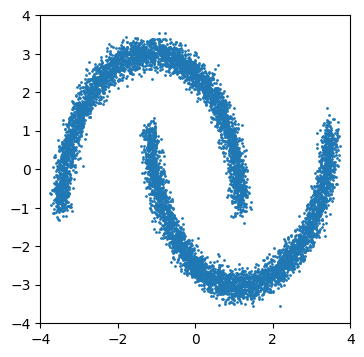

In [2]:
data = datasets.make_moons(8000, noise=0.05)[0].astype("float32")
norm = layers.Normalization()
norm.adapt(data)
train_data = norm(data) * 2

fig = plt.figure(figsize=(4, 4))
subplot = fig.add_subplot(1, 1, 1)
subplot.set_xlim((-4, 4))
subplot.set_ylim((-4, 4))
_ = subplot.scatter(train_data[:, 0], train_data[:, 1], s=1)

In [3]:
encoder = models.Sequential(name='encoder')
encoder.add(layers.Dense(64, activation='relu', input_shape=(2,)))
encoder.add(layers.Dense(64, activation='relu'))
encoder.add(layers.Dense(64, activation='relu'))
encoder.add(layers.Dense(64, activation='relu'))
encoder.add(layers.Dense(4, name='mean_and_log_var'))

encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                192       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 mean_and_log_var (Dense)    (None, 4)                 260       
                                                                 
Total params: 12,932
Trainable params: 12,932
Non-trainable params: 0
_________________________________________________________________


In [4]:
sampler = models.Sequential(name='sampler')
sampler.add(layers.Lambda(
    lambda x: x[:, 0:2] + tf.exp(0.5 * x[:, 2:4]) * K.random_normal(shape=(tf.shape(x)[0], 2)),
    input_shape=(4,), name='sampled_embedding'))

sampler.summary()

Model: "sampler"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sampled_embedding (Lambda)  (None, 2)                 0         
                                                                 
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


In [5]:
decoder = models.Sequential(name='decoder')
decoder.add(layers.Dense(64, input_shape=(2, )))
decoder.add(layers.Dense(64, activation='relu'))
decoder.add(layers.Dense(64, activation='relu'))
decoder.add(layers.Dense(64, activation='relu'))
decoder.add(layers.Dense(2))

decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 64)                192       
                                                                 
 dense_5 (Dense)             (None, 64)                4160      
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 64)                4160      
                                                                 
 dense_8 (Dense)             (None, 2)                 130       
                                                                 
Total params: 12,802
Trainable params: 12,802
Non-trainable params: 0
_________________________________________________________________


In [6]:
model_input = tf.keras.Input(shape=(2,))
model_output = layers.Concatenate(name='prediction_with_mean_log_var')(
    [encoder(model_input),
     decoder(sampler(encoder(model_input)))
    ])

model = models.Model(model_input, model_output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2)]          0           []                               
                                                                                                  
 encoder (Sequential)           (None, 4)            12932       ['input_1[0][0]',                
                                                                  'input_1[0][0]']                
                                                                                                  
 sampler (Sequential)           (None, 2)            0           ['encoder[1][0]']                
                                                                                                  
 decoder (Sequential)           (None, 2)            12802       ['sampler[0][0]']            

In [7]:
def custom_loss(y_true, y_pred):
    mean, log_var, pred = y_pred[:, 0:2], y_pred[:, 2:4], y_pred[:, 4:]
    reconstruction_loss = losses.mse(pred, y_true)
    kl_loss = tf.reduce_mean(tf.reduce_sum(
        -0.5 * (1 + log_var - tf.square(mean) - tf.exp(log_var)), axis=1))
    loss = reconstruction_loss + 0.45 * kl_loss
    return loss

In [8]:
model.compile(optimizer='adam', loss=custom_loss)

In [9]:
%%time
history = model.fit(train_data, train_data, batch_size=2000, epochs=200, verbose=0)

CPU times: user 32.4 s, sys: 1.03 s, total: 33.4 s
Wall time: 34.6 s


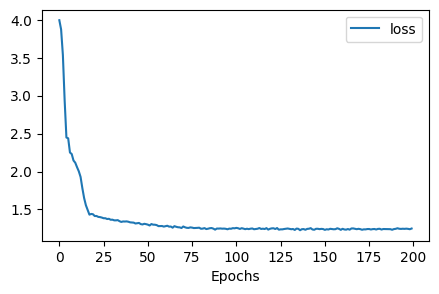

In [10]:
df = DataFrame({'loss': history.history['loss']})
df.index.name = 'Epochs'
ax = df.plot(figsize=(5, 3))

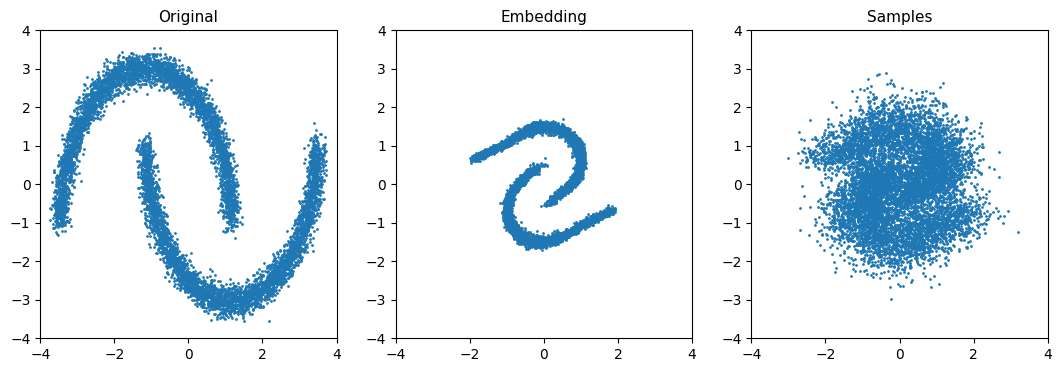

In [14]:
embeddings = encoder.predict(train_data, verbose=0)
samples = sampler.predict(embeddings, verbose=0)
embeddings = embeddings[:, :2]

fig = plt.figure(figsize=(13, 4))
subplot = fig.add_subplot(1, 3, 1)
subplot.set_xlim((-4, 4))
subplot.set_ylim((-4, 4))
subplot.set_title('Original', fontsize=11)
_ = subplot.scatter(train_data[:, 0], train_data[:, 1], s=1)

subplot = fig.add_subplot(1, 3, 2)
subplot.set_xlim((-4, 4))
subplot.set_ylim((-4, 4))
subplot.set_title('Embedding', fontsize=11)
_ = subplot.scatter(embeddings[:, 0], embeddings[:, 1],s=1)

subplot = fig.add_subplot(1, 3, 3)
subplot.set_xlim((-4, 4))
subplot.set_ylim((-4, 4))
subplot.set_title('Samples', fontsize=11)
_ = subplot.scatter(samples[:, 0], samples[:, 1],s=1)

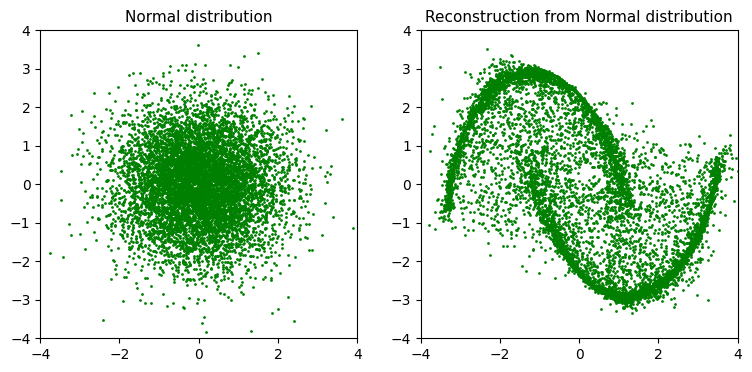

In [12]:
samples = np.random.multivariate_normal([0, 0], [[1, 0], [0, 1]], size=8000)
reconstruction = decoder.predict(samples, verbose=0)

fig = plt.figure(figsize=(9, 4))
subplot = fig.add_subplot(1, 2, 1)
subplot.set_xlim((-4, 4))
subplot.set_ylim((-4, 4))
subplot.set_title('Normal distribution', fontsize=11)
_ = subplot.scatter(samples[:, 0], samples[:, 1], color='green', s=1)

subplot = fig.add_subplot(1, 2, 2)
subplot.set_xlim((-4, 4))
subplot.set_ylim((-4, 4))
subplot.set_title('Reconstruction from Normal distribution', fontsize=11)
_ = subplot.scatter(reconstruction[:, 0], reconstruction[:, 1], color='green', s=1)